In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [110]:
## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [111]:
## What signals do we have?

print(df1.columns.values)

['DATETIME' 'L_T1' 'L_T2' 'L_T3' 'L_T4' 'L_T5' 'L_T6' 'L_T7' 'F_PU1'
 'S_PU1' 'F_PU2' 'S_PU2' 'F_PU3' 'S_PU3' 'F_PU4' 'S_PU4' 'F_PU5' 'S_PU5'
 'F_PU6' 'S_PU6' 'F_PU7' 'S_PU7' 'F_PU8' 'S_PU8' 'F_PU9' 'S_PU9' 'F_PU10'
 'S_PU10' 'F_PU11' 'S_PU11' 'F_V2' 'S_V2' 'P_J280' 'P_J269' 'P_J300'
 'P_J256' 'P_J289' 'P_J415' 'P_J302' 'P_J306' 'P_J307' 'P_J317' 'P_J14'
 'P_J422' 'ATT_FLAG']


In [112]:
## Finding correlation

correlation = df1.corr()
correlated_data= correlation
# correlation = correlation.abs()
correlation = correlation.unstack()
corr = correlation.sort_values(kind="quicksort",ascending=False)


## Autocorrelation
df1_columns = df1.columns.values.tolist()
df1_columns.remove('DATETIME')
df1_columns.remove('ATT_FLAG')
dw_stat = pd.Series(sm.stats.durbin_watson(df1[df1_columns]))

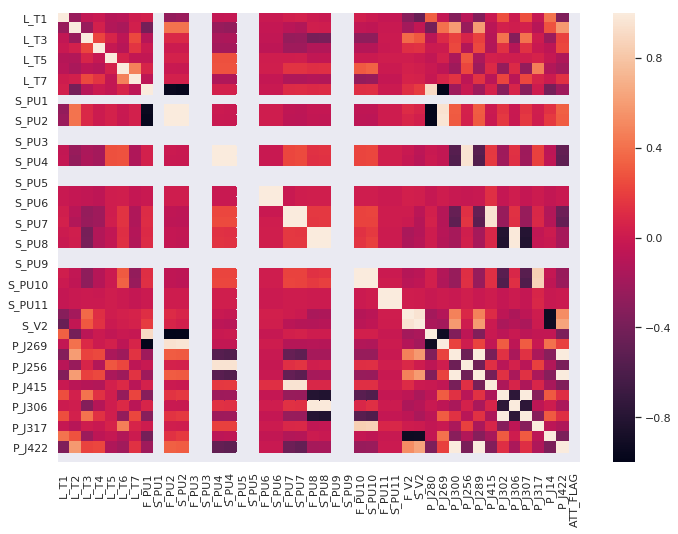

In [113]:
## Heatmap all signals

sns.heatmap(correlated_data)

In [114]:
## Sort correlation for later use

corr = corr.to_frame().reset_index()
corr.columns = ["1","2","correlation"]

corr = corr[corr["correlation"] != 1]
corr = corr[corr["1"] != "ATT_FLAG"]
corr = corr.dropna()


/usr/local/lib/python3.7/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


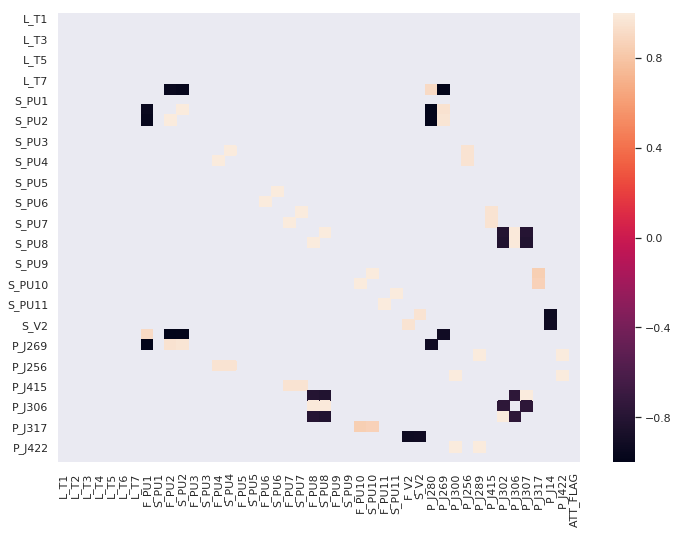

In [115]:
## Plot only most correlated values

correlheat = correlated_data[correlheat != 1]
correlheat = correlheat[correlheat != "ATT_FLAG"]
correlheat = correlheat[abs(correlheat) > 0.7]

sns.heatmap(correlheat)

In [116]:
## Show most correlated signals
corr

,1,2,correlation
36,P_J302,P_J307,0.999962
37,P_J307,P_J302,0.999962
38,F_PU6,S_PU6,0.999887
39,S_PU6,F_PU6,0.999887
40,P_J289,P_J300,0.999858
41,P_J300,P_J289,0.999858
42,F_PU8,S_PU8,0.999141
43,S_PU8,F_PU8,0.999141
44,S_PU4,F_PU4,0.998649
45,F_PU4,S_PU4,0.998649


In [130]:
idx = len(df1) - 1 if len(df1) % 24 else len(df1)
test = df1[:idx].groupby(df1.index[:idx] // 24).mean()

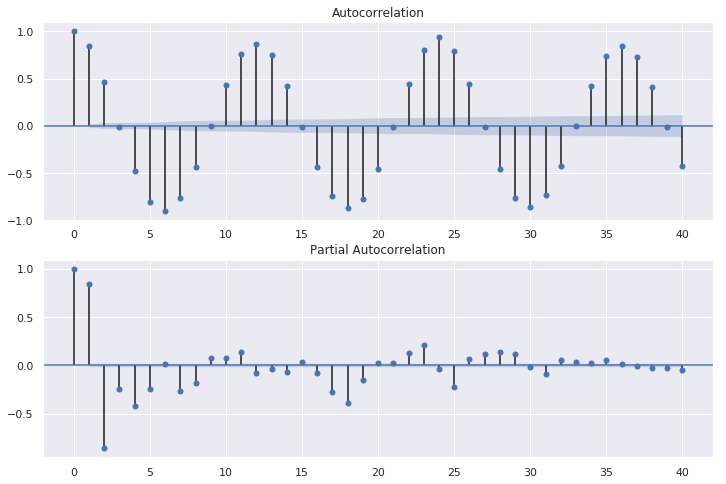

In [149]:
## Plot correlations

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1["L_T3"].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1["L_T3"], lags=40, ax=ax2)

In [16]:
len(df1.columns)

45

In [ ]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')
